## Load dataset for model 

In [1]:
import pandas as pd
from io import BytesIO
from google.colab import files

fileupload = files.upload()
SMStrain = pd.read_csv(BytesIO(fileupload['SMS_train.csv']), encoding= 'unicode_escape')
fileupload1 = files.upload()
SMStest = pd.read_csv(BytesIO(fileupload1['SMS_test.csv']), encoding= 'unicode_escape')

Saving SMS_train.csv to SMS_train (2).csv


Saving SMS_test.csv to SMS_test (2).csv


## Concatenate pandas dataframe

In [2]:
SMSTotal = pd.concat([SMStrain, SMStest])
print('Size of concatenated data: {}'.format(SMSTotal.shape))
print(SMSTotal.head())

Size of concatenated data: (1082, 3)
   S. No.                                       Message_body     Label
0       1                         Rofl. Its true to its name  Non-Spam
1       2  The guy did some bitching but I acted like i'd...  Non-Spam
2       3  Pity, * was in mood for that. So...any other s...  Non-Spam
3       4               Will ü b going to esplanade fr home?  Non-Spam
4       5  This is the 2nd time we have tried 2 contact u...      Spam


## Quick overview/description of data

In [3]:
SMSTotal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1082 entries, 0 to 124
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   S. No.        1082 non-null   int64 
 1   Message_body  1082 non-null   object
 2   Label         1082 non-null   object
dtypes: int64(1), object(2)
memory usage: 33.8+ KB


## Find cateogories under the target label

In [4]:
SMSTotal['Label'].value_counts()

Non-Spam    884
Spam        198
Name: Label, dtype: int64

## Label encode target for machine recognition

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
SMSTotal['Label'] = le.fit_transform(SMSTotal['Label'])

SMSTotal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1082 entries, 0 to 124
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   S. No.        1082 non-null   int64 
 1   Message_body  1082 non-null   object
 2   Label         1082 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 33.8+ KB


## Check cleaned data

In [6]:
SMSTotal.head()

,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,0
1,2,The guy did some bitching but I acted like i'd...,0
2,3,"Pity, * was in mood for that. So...any other s...",0
3,4,Will ü b going to esplanade fr home?,0
4,5,This is the 2nd time we have tried 2 contact u...,1


## Segregation of data into features and target

In [7]:
X = SMSTotal['Message_body']
y = SMSTotal['Label']

## Split of data into training and testing

In [8]:
from sklearn.model_selection import train_test_split

text_train, text_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

## Bag-of-words feature extraction

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print('X train:\n{}'.format(repr(X_train)))

X train:
<757x388 sparse matrix of type '<class 'numpy.int64'>'
	with 6589 stored elements in Compressed Sparse Row format>


## Overview of unique features

In [10]:
fea_names = vect.get_feature_names()
print('Number of features: {}'.format(len(fea_names)))
print('First 20 features:\n{}'.format(fea_names[:20]))
print('Features 1000 to 1020:\n{}'.format(fea_names[200:220]))

Number of features: 388
First 20 features:
['000', '04', '10', '100', '1000', '11', '12hrs', '150p', '150ppm', '16', '18', '1st', '2000', '2003', '2nd', '30', '50', '500', '800', '87066']
Features 1000 to 1020:
['me', 'meet', 'meeting', 'message', 'min', 'mins', 'miss', 'mob', 'mobile', 'mobiles', 'money', 'more', 'morning', 'most', 'msg', 'much', 'music', 'my', 'name', 'need']


## Model with countvectorizer

In [11]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression()
logreg = lr.fit(X_train, y_train)

X_test = vect.transform(text_test)

param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 150, 200]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

print('Best validation score: {:.3f}'.format(grid.best_score_))
print('Best parameter: {}'.format(grid.best_params_))
print('Score: {:.3f}'.format(grid.score(X_test, y_test)))

Best validation score: 0.971
Best parameter: {'C': 10}
Score: 0.954


## Model with term frequency-inverse document frequency (tf-idf)

In [12]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

# Define model
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression())

# Different combinations of parameters
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 150, 200],
              'tfidfvectorizer__ngram_range': [(1,1),(1,2),(1,3)]}

# Search for the best model
grid = GridSearchCV(pipe, param_grid, cv=5)

# Fit in the training set data
grid.fit(text_train, y_train)

print('Best validation score: {:.3f}'.format(grid.best_score_))
print('Best parameter: {}'.format(grid.best_params_))
print('Score: {:.3f}'.format(grid.score(text_test, y_test)))

Best validation score: 0.974
Best parameter: {'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}
Score: 0.960


## Identify which features are more and less commonly used

In [13]:
# Transform training dataset
vectortf = grid.best_estimator_.named_steps['tfidfvectorizer']
Xtransform = vectortf.transform(text_train)

# Get the maximum value for each unique feature
max_value = Xtransform.max(axis=0).toarray().ravel()

# Sort the array from the smallest to largest number according to their index position in max_value
sorted = max_value.argsort()

# Obtain all the feature names for tfidfvectorizer
feature_names = np.array(vectortf.get_feature_names())

# For more common terms
print('Features with low tfidf:\n {}'.format(feature_names[sorted[:20]]))
# For rarer terms
print('Features with high tfidf:\n {}'.format(feature_names[sorted[-20:]]))

Features with low tfidf:
 ['shows 800' '800 un redeemed' 'un' 'un redeemed' 'points call' 'redeemed'
 '800 un' 'redeemed points call' 'redeemed points' 'un redeemed points'
 'shows 800 un' '800' '04' 'to the latest' 'update to' 'update to the'
 'prize guaranteed call' 'prize guaranteed' 'valid 12hrs'
 'guaranteed call']
Features with high tfidf:
 ['smile' 'another' 'there' 'week' 'fine' 'face' 'which' 'ur' 'told' 'ah'
 'that' 'have' 'home' 'in' 'out' 'lor' 'ok' 'not' 'with' 'yup']


In [14]:
!pip install mglearn
import mglearn

## Visualize feature coefficient (postive coefficient = spam , negative coefficient = non-spam)

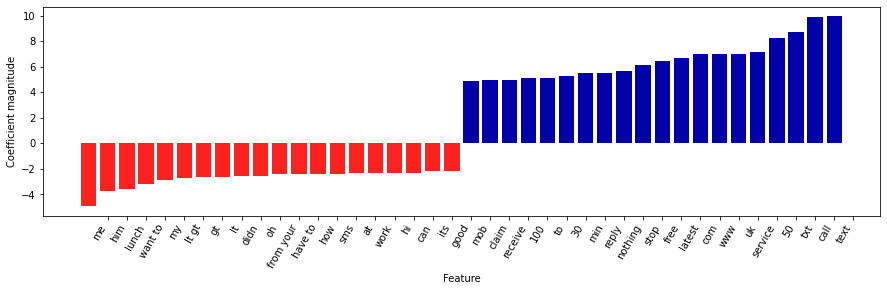

In [15]:
# With ngram_range of (1,3)
mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps['logisticregression'].coef_, feature_names, n_top_features=20)

## Visualize performance of model for different combinations of parameter

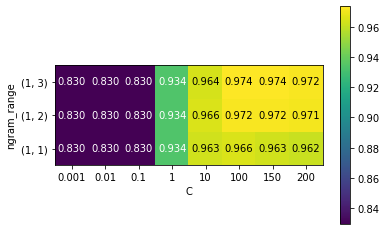

In [16]:
import matplotlib.pyplot as plt

# Extract scores from model
scores = grid.cv_results_['mean_test_score'].reshape(-1,3).T

# Plot heat map
heatmap = mglearn.tools.heatmap(
    scores, xlabel='C', ylabel='ngram_range', cmap='viridis', fmt='%.3f',
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])

plt.colorbar(heatmap)

## Visualize coefficient for one word only

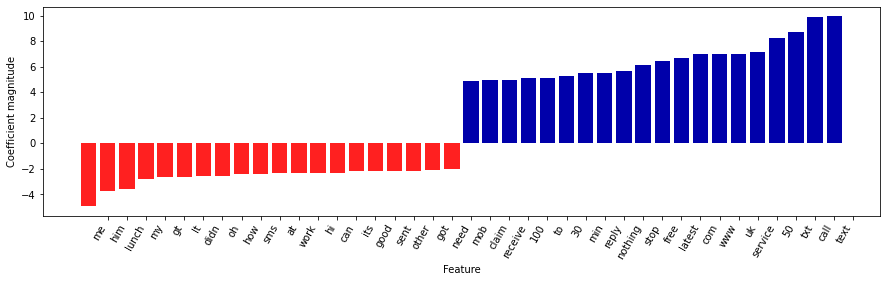

In [17]:
# With ngram_range of (1,1) / 1-gram features
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
gram1 = np.array([len(feature.split(" ")) for feature in feature_names]) == 1

# Visualize 1-gram features
mglearn.tools.visualize_coefficients(coef.ravel()[gram1], feature_names[gram1], n_top_features=20)

## Visualize coefficient for three words only

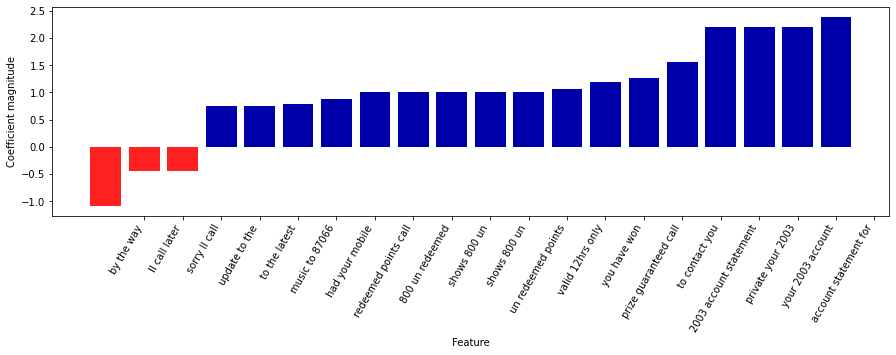

In [18]:
# 3-gram features
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
gram3 = np.array([len(feature.split(" ")) for feature in feature_names]) == 3

# Visualize 3-gram features
mglearn.tools.visualize_coefficients(coef.ravel()[gram3], feature_names[gram3], n_top_features=10)